<h1>Hawkes Split Distribution</h1><br>
Training and simulation of a Hawkes process model (EM kernel) on the RHS of the split distribution.

# Licence
BSD 3-Clause License

Copyright (c) 2020, Cyber Security Research Centre Limited
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.



<h2>Setup</h2>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tick.plot import plot_hawkes_kernels
import os
from HelperFunctions import MultiHist
from TickHelper import TrainEM, SimEM, SavedModel

c:\users\ricard grace\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
#convenience variables
sec = 1000000000
split_time = 0.00025

#tweakable parameters
data_csv = 'data.csv' #the raw data
c_id = 4 #client (dataset to use)
train_ratio = 0.8 #ratio of how much data for training and testing (0 - 1)
#the maximum interarrival time to model. This will change based on the dataset.
#Generally set it high enough to capture all the interarrivals. for client 4, 36 seconds is good enough
k_time = 36
#how many intervals to consider when training each model
#Will train 1 model with each kernel size (warning: larger k_sizes vastly increase training time)
k_sizes = [18, 36, 72, 180, 360, 720]
sim_time = 200000 #time frame to simulate points up to in seconds

#files
#save model = f"HawkesEM_{k_sizes[i]}_RHS_model_c{c_id}.npz" ###if you want to change this you will need to modify two places in the evaluation section
#save dist = f"HawkesEM_{k_sizes[i]}_RHS_dist_c{c_id}.npz" ###if you want to change this you will need to modify it in evaluation (in one place)
dist_folder = "saved_dist"
model_folder = "saved_model"

<h2>Data Loading</h2>

In [3]:
#only include deltas > split_time and shuffle their order to destroy any previous relationships
#should only allow learning the intensity
X = pd.read_csv(data_csv)
deltas = np.ediff1d(X[X.client_id == c_id].time.apply(lambda x:x/sec))
#np.random.shuffle(deltas[deltas > split_time])
times = np.cumsum(deltas[deltas > split_time])

#split into train, val and test sets
times_train = times[:int(deltas.size*train_ratio)]
times_test = times[int(deltas.size*train_ratio):]

<h2>Training</h2><br>Uses a Hawkes EM kernel to model the data since it is clear that an exponential kernel is not good enough

In [4]:
learners = []
for k_size in k_sizes:
    em_learner = TrainEM([times], k_time=k_time, k_size=k_size)
    learners.append(em_learner)

Launching the solver HawkesEM...
  n_iter  | rel_baseline | rel_kernel
        0 |     6.89e-01 |   7.51e-01
       10 |     1.39e-02 |   2.86e-03
       20 |     4.72e-03 |   5.02e-04
       30 |     1.72e-03 |   1.91e-04
       40 |     7.35e-04 |   9.06e-05
       50 |     3.63e-04 |   5.01e-05
       60 |     2.00e-04 |   3.07e-05
       70 |     1.21e-04 |   2.01e-05
       80 |     7.78e-05 |   1.38e-05
       90 |     5.26e-05 |   9.85e-06
      100 |     3.70e-05 |   7.22e-06
      110 |     2.68e-05 |   5.41e-06
      120 |     1.99e-05 |   4.13e-06
      130 |     1.51e-05 |   3.20e-06
      140 |     1.16e-05 |   2.52e-06
      150 |     9.05e-06 |   2.00e-06
Done solving using HawkesEM in 133.80222964286804 seconds
Launching the solver HawkesEM...
  n_iter  | rel_baseline | rel_kernel
        0 |     6.90e-01 |   7.83e-01
       10 |     1.11e-02 |   1.38e-03
       20 |     3.75e-03 |   2.47e-04
       30 |     1.44e-03 |   9.74e-05
       40 |     6.74e-04 |   4.76e-05
  

<h2>Evaluation</h2>

<h3>Model Kernels</h3><br>
Contains graphs of the kernels created through training

kernel_size=18
kernel_baseline=[0.15614207]


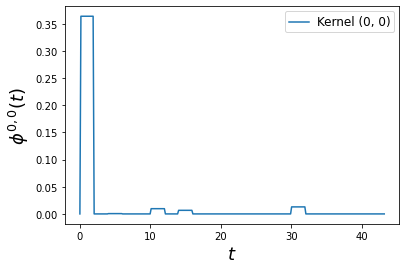

kernel_size=36
kernel_baseline=[0.13119463]


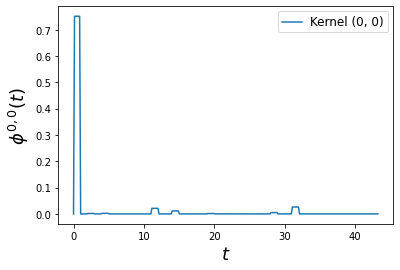

kernel_size=72
kernel_baseline=[0.10813109]


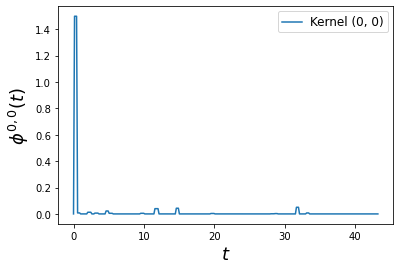

kernel_size=180
kernel_baseline=[0.09777939]


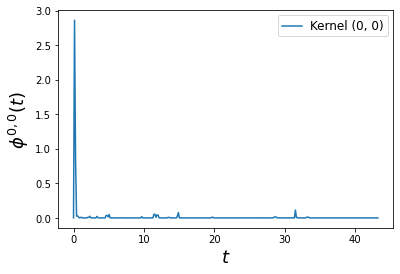

kernel_size=360
kernel_baseline=[0.09289677]


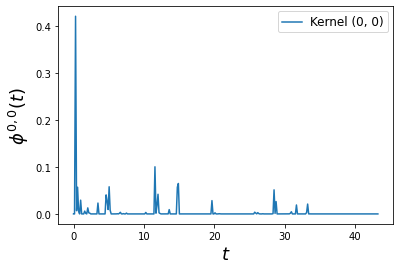

kernel_size=720
kernel_baseline=[0.07394994]


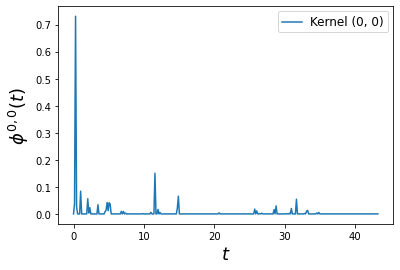

In [5]:
#display and save each kernel learned
for i, learner in enumerate(learners):
    #save
    smodel = SavedModel(learner, k_time, k_sizes[i])
    fname = os.path.join(model_folder, f"HawkesEM_{k_sizes[i]}_RHS_model_c{c_id}.npz")
    smodel.Save(fname)
    
    #display
    print(f"kernel_size={k_sizes[i]}")
    print(f"kernel_baseline={smodel.baseline}")
    plot_hawkes_kernels(learner)
    plt.show()

<h3>Model Simulation and Statistics</h3><br>
Models are simulated to generate new points and statistics computed on those points

In [6]:
for size in k_sizes:
    #load the model
    fname = os.path.join(model_folder, f"HawkesEM_{size}_RHS_model_c{c_id}.npz")
    smodel = np.load(fname, allow_pickle=True)['savedmodel'].item()
    
    #simulate new points
    synth_deltas = np.ediff1d(SimEM(smodel, time=sim_time))
    
    #print the stats
    print(f"=== Kernel Size: {smodel.k_size} ===")
    print(f"Total points: {len(synth_deltas)}")
    print(f"Intensity Baseline: {smodel.baseline}")
    print(f"mean: {np.mean(synth_deltas)}")
    print(f"median: {np.median(synth_deltas)}")
    print(f"std: {np.std(synth_deltas)}")
    print(f"min: {np.min(synth_deltas)}")
    print(f"max: {np.max(synth_deltas)}")
    print("===========================")
    print()
    
    #save the simulation
    fname = os.path.join(dist_folder, f"HawkesEM_{size}_RHS_dist_c{c_id}.npz")
    np.savez(fname, deltas=synth_deltas)

=== Kernel Size: 18 ===
Total points: 54702
Intensity Baseline: [0.15614207]
mean: 3.6559848818865257
median: 1.3239395489399612
std: 5.170358747512402
min: 4.669869667850435e-06
max: 54.01181207194895

=== Kernel Size: 36 ===
Total points: 47539
Intensity Baseline: [0.13119463]
mean: 4.206853240549506
median: 1.3318737582594622
std: 6.211026763531047
min: 2.9620387067552656e-05
max: 70.89550009405593

=== Kernel Size: 72 ===
Total points: 21768
Intensity Baseline: [0.10813109]
mean: 9.187712353491305
median: 6.311129027490097
std: 9.304489282666376
min: 0.00041903904639184475
max: 100.11585958194337

=== Kernel Size: 180 ===
Total points: 19509
Intensity Baseline: [0.09777939]
mean: 10.251264811769973
median: 7.175547213759273
std: 10.146697652289934
min: 0.0009480030566919595
max: 91.1322785280936

=== Kernel Size: 360 ===
Total points: 18763
Intensity Baseline: [0.09289677]
mean: 10.658211247108072
median: 7.395264954742743
std: 10.682658179104584
min: 8.712190901860595e-05
max: 120